In [1]:
#引入库
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import pymysql

### 数据读入

In [2]:
#连接数据库，读入数据
db = pymysql.connect("localhost",'root','','TESTDB')
sql = "select * from dzdp;"
data = pd.read_sql(sql,db)

In [3]:
db.close()

### 数据概要

In [4]:
data.shape

(32483, 8)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32483 entries, 0 to 32482
Data columns (total 8 columns):
cus_id          32483 non-null object
comment_time    32483 non-null object
comment_star    32483 non-null object
cus_comment     32483 non-null object
kouwei          32483 non-null object
huanjing        32483 non-null object
fuwu            32483 non-null object
shopID          32483 non-null object
dtypes: object(8)
memory usage: 2.0+ MB


In [6]:
data.head()

,cus_id,comment_time,comment_star,cus_comment,kouwei,huanjing,fuwu,shopID
0,迷糊泰迪,2018-09-20 06:48,sml-str40,南信 算是 广州 著名 甜品店吧 ，好几个 时间段 路过 ，都是 座无虚席。 看着 餐单 ...,非常好,好,好,518986
1,稱霸幼稚園,2018-09-22 21:49,sml-str40,中午吃完了所谓的早茶 回去放下行李 休息了会 就来吃下午茶了[服务]两层楼 楼下只能收现金...,很好,很好,很好,518986
2,爱吃的美美侠,2018-09-22 22:16,sml-str40,【VIP冲刺王者战队】【吃遍蓉城战队】【VIP有特权】五月份和好朋友毕业旅行来了广州。我们都...,很好,很好,很好,518986
3,姜姜会吃胖,2018-09-19 06:36,sml-str40,都说来广州吃糖水就要来南信招牌姜撞奶，红豆双皮奶牛三星，云吞面一楼现金，二楼微信支付宝位置不...,非常好,很好,很好,518986
4,forevercage,2018-08-24 17:58,sml-str50,一直很期待也最爱吃甜品，广州的甜品很丰富很多样，来之前就一直想着一定要过来吃到腻，今天总算实...,非常好,很好,很好,518986


### 探索性分析

In [7]:
data['comment_star'].value_counts()

sml-str40    10849
sml-str50     9067
NAN           5636
sml-str30     5152
sml-str20      982
sml-str10      796
sml-str1         1
Name: comment_star, dtype: int64

In [8]:
data.loc[data['comment_star'] == 'sml-str1','comment_star'] = 'sml-str10'

In [9]:
data['stars'] = data['comment_star'].str.findall(r'\d+').str.get(0)
data['stars'] = data['stars'].astype(float)/10
data['stars'].value_counts()

4.0    10849
5.0     9067
3.0     5152
2.0      982
1.0      797
Name: stars, dtype: int64

In [10]:
import seaborn as sns

D:\SOFTWARE\Anaconda\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


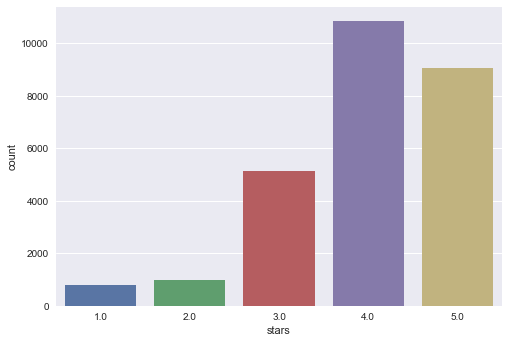

In [11]:
sns.countplot(data=data,x='stars')

D:\SOFTWARE\Anaconda\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


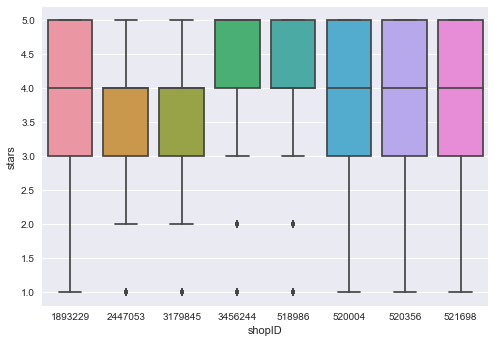

In [12]:
sns.boxplot(data=data,x='shopID',y='stars')

In [13]:
data.comment_time = pd.to_datetime(data.comment_time.str.findall(r'\d{4}-\d{2}-\d{2} .+').str.get(0))
data.set_index(data.comment_time)

,cus_id,comment_time,comment_star,cus_comment,kouwei,huanjing,fuwu,shopID,stars
comment_time,,,,,,,,,
2018-09-20 06:48:00,迷糊泰迪,2018-09-20 06:48:00,sml-str40,南信 算是 广州 著名 甜品店吧 ，好几个 时间段 路过 ，都是 座无虚席。 看着 餐单 ...,非常好,好,好,518986,4.0
2018-09-22 21:49:00,稱霸幼稚園,2018-09-22 21:49:00,sml-str40,中午吃完了所谓的早茶 回去放下行李 休息了会 就来吃下午茶了[服务]两层楼 楼下只能收现金...,很好,很好,很好,518986,4.0
2018-09-22 22:16:00,爱吃的美美侠,2018-09-22 22:16:00,sml-str40,【VIP冲刺王者战队】【吃遍蓉城战队】【VIP有特权】五月份和好朋友毕业旅行来了广州。我们都...,很好,很好,很好,518986,4.0
2018-09-19 06:36:00,姜姜会吃胖,2018-09-19 06:36:00,sml-str40,都说来广州吃糖水就要来南信招牌姜撞奶，红豆双皮奶牛三星，云吞面一楼现金，二楼微信支付宝位置不...,非常好,很好,很好,518986,4.0
2018-08-24 17:58:00,forevercage,2018-08-24 17:58:00,sml-str50,一直很期待也最爱吃甜品，广州的甜品很丰富很多样，来之前就一直想着一定要过来吃到腻，今天总算实...,非常好,很好,很好,518986,5.0
2018-09-03 13:12:00,凸槌槌,2018-09-03 13:12:00,sml-str30,甜品一直是我的心头肉，既然来了广州，不吃甜品是不会罢休的 ，可惜还有好几家没有办法前往。南信...,好,很好,很好,518986,3.0
2018-08-15 00:39:00,superclampfa,2018-08-15 00:39:00,sml-str40,补发点评：目前为止吃过的最好吃的双皮奶，没有之一！去广州一定要尝试他家的双皮奶！不然是人生一...,非常好,很好,很好,518986,4.0
2018-09-08 21:13:00,梦中的纸马,2018-09-08 21:13:00,sml-str30,"在上下九步行街闲逛，一直觉得未能找到网上所说的""必吃小食""，有些失望。走着走着，无意中发现南...",好,一般,好,518986,3.0
2018-09-15 22:26:00,初小正,2018-09-15 22:26:00,sml-str40,广州很胖人…忍不住的要吃糖水甜品。南信的店面很好找，上下九旅游区，就餐环境一般，毕竟游人实在...,非常好,很好,非常好,518986,4.0


### 时间特征提取

In [14]:
data['year'] = data.comment_time.dt.year
data['month'] = data.comment_time.dt.month
data['weekday'] = data.comment_time.dt.weekday
data['hour'] = data.comment_time.dt.hour

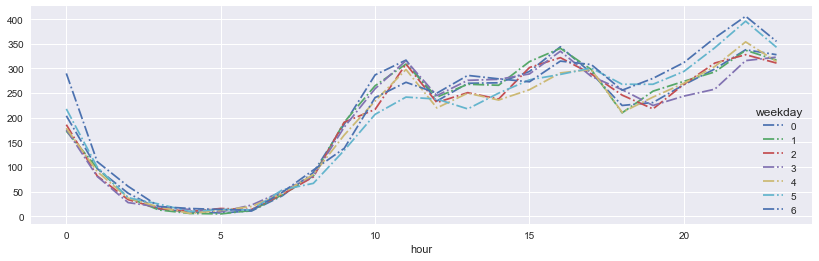

In [15]:
fig1, ax1=plt.subplots(figsize=(14,4))
df=data.groupby(['hour', 'weekday']).count()['cus_id'].unstack()
df.plot(ax=ax1, style='-.')
plt.show()

In [16]:
data['comment_len'] = data['cus_comment'].str.len()

D:\SOFTWARE\Anaconda\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


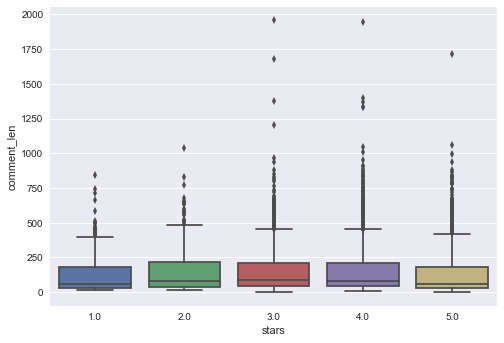

In [17]:
sns.boxplot(x='stars',y='comment_len',data=data)

In [19]:
data.to_csv('data.csv',index=False)